In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.size'] = 20

In [2]:
import networkx as nx
import numpy as np
from cvxopt import matrix

import graph as gph
from netbfe import *

In [3]:
def cubeLayout( origin=False):
    front = np.array( [[0, 0],
                       [0, 1],
                       [1, 0],
                       [1, 1]])
    back = front + np.array( [ 0.5, np.sqrt(3)/6])
    if not origin:
        return np.concatenate( [front, back])
    o = np.array( [np.sqrt(3)/6, -0.25])
    return np.concatenate( [front, back, [o]])

We will use the binding free energy calculation for 8 COX-2 ligands to illustrate how to use DiffNet to allocate the samplings for absolute binding free energy calculations for individual molecules and relative binding free energy calculations between select pairs of molecules.

Let's get the parameters

In [4]:
cox2 = COX2params()

## Statistical fluctuations in binding free energy calculations

The statistical fluctuations in the binding free energy calculations.  $s_{ii}$ is the fluctuation associated with the absolute binding free energy calculation for molecule $i$, $s_{ij}$ is the fluctuation associated with the relative binding free energy calculation between molecules $i$ and $j$.

In [5]:
sCOX2 = cox2['s']

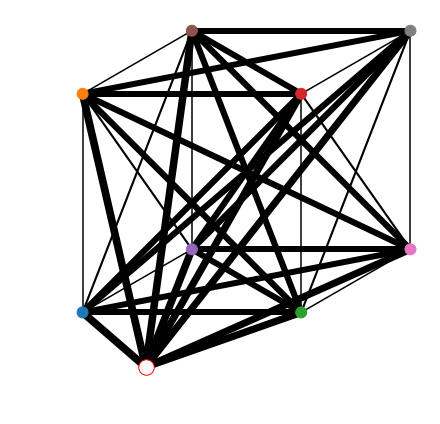

In [6]:
def plot_sCOX2( s=sCOX2):
    fig, ax = plt.subplots( figsize=(7, 7))
    gph.draw_diffnet_graph( gph.diffnet_to_graph( s), pos=cubeLayout( True), ax=ax, widthscale=1.5e-1, nodescale=15, node_color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8])
    ax.set_aspect( 1)
    ax.axis('off')
    return fig

_ = plot_sCOX2()

Here each filled circle represents a molecule.  The edge connecting a filled circle $i$ to the empty circle represents absolute binding free energy calculation for the corresponding molecule $i$.  The width of the edge is proportional to the associated fluctuation $s$.

## Calculations without reference experimental values

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  5e+00  2e+00  1e+00
 1:  5.5598e+00  5.6404e+00  3e+02  1e+00  6e-01  3e-01
 2:  8.8118e+00  9.0909e+00  3e+02  1e+00  6e-01  5e-01
 3:  2.3753e+01  2.4292e+01  7e+01  3e-01  1e-01  6e-01
 4:  2.8945e+01  2.9341e+01  4e+01  1e-01  7e-02  4e-01
 5:  2.9215e+01  2.9740e+01  6e+01  1e-01  8e-02  6e-01
 6:  4.0407e+01  4.0759e+01  4e+01  8e-02  4e-02  4e-01
 7:  4.3576e+01  4.3687e+01  2e+01  3e-02  1e-02  1e-01
 8:  4.8297e+01  4.8372e+01  9e+00  2e-02  8e-03  8e-02
 9:  5.0302e+01  5.0312e+01  1e+00  2e-03  1e-03  1e-02
10:  5.0580e+01  5.0583e+01  4e-01  6e-04  3e-04  3e-03
11:  5.0701e+01  5.0702e+01  4e-02  7e-05  4e-05  4e-04
12:  5.0716e+01  5.0716e+01  3e-03  5e-06  3e-06  3e-05
13:  5.0717e+01  5.0717e+01  2e-04  3e-07  2e-07  2e-06
14:  5.0717e+01  5.0717e+01  5e-05  9e-08  5e-08  5e-07
15:  5.0717e+01  5.0717e+01  5e-06  8e-09  4e-09  5e-08
Optimal solution found.


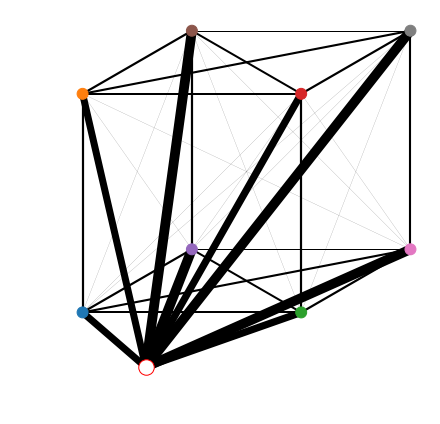

In [7]:
def without_references( s=sCOX2, N=1000., integer_n=True):
    n = networkBFEalloc( s, N)
    if integer_n:
        nint = round_to_integers( n)
        n = matrix( nint[:], n.size, tc='d')
    G = gph.diffnet_to_graph( n)
    fig, ax = plt.subplots( figsize=(7, 7))
    gph.draw_diffnet_graph( G, pos=cubeLayout( True), ax=ax, widthscale=1e-1, nodescale=15, node_color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8])
    ax.set_aspect( 1)
    ax.axis( 'off')
    return fig, n

_ = without_references()

Here the width of each edge signifies the allocated samples $n$ of the corresponding calculation. Without reference values, most of the computational samplings are allocated to the absolute binding free energy calculations, which are associated with larger statistical fluctuations ($s_i$).

## Calculations with reference experimental values

In [8]:
def reference_values( references):
    dG0 = cox2['dG0'].copy()
    delta = cox2['delta'].copy()
    for i in xrange( len(dG0)):
        if i not in references:
            dG0[i] = np.nan
            delta[i] = np.infty
    return dG0, delta

We will consider a network of binding free energy calculations where we have reference experimental binding free energies for some molecules, with attendant experimental error bars ($\Delta G_i \pm \delta_i$)

In [9]:
def with_references( references, s=sCOX2, N=1000., integer_n=True):
    dG0, delta = reference_values( references)
    n = networkBFEalloc( s, N, delta)
    if integer_n:
        nint = round_to_integers( n)
        n = matrix( nint[:], n.size, tc='d')
    G = gph.diffnet_to_graph( n)
    fig, ax = plt.subplots( figsize=(7, 7))
    gph.draw_diffnet_graph( G, pos=cubeLayout( True), ax=ax, widthscale=100./N, nodescale=15, node_color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8])
    ax.set_aspect( 1)
    ax.axis( 'off')
    return fig, n

### With 1 reference molecule

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.0000e+01  1e+03  1e+00  2e+00  1e+00
 1:  5.2053e+00 -5.9054e+00  3e+02  2e-01  5e-01  3e-01
 2:  7.5175e+00 -3.6091e+00  3e+02  2e-01  6e-01  5e-01
 3:  1.7399e+01  1.4934e+01  7e+01  6e-02  1e-01  6e-01
 4:  1.6341e+01  1.5296e+01  3e+01  3e-02  6e-02  3e-01
 5:  1.7364e+01  1.6334e+01  4e+01  3e-02  6e-02  3e-01
 6:  1.9594e+01  1.9319e+01  1e+01  7e-03  2e-02  9e-02
 7:  1.8686e+01  1.8567e+01  4e+00  3e-03  8e-03  4e-02
 8:  1.8822e+01  1.8781e+01  1e+00  1e-03  3e-03  1e-02
 9:  1.8823e+01  1.8819e+01  2e-01  1e-04  3e-04  1e-03
10:  1.8821e+01  1.8819e+01  5e-02  4e-05  9e-05  5e-04
11:  1.8819e+01  1.8819e+01  6e-03  5e-06  1e-05  6e-05
12:  1.8819e+01  1.8819e+01  2e-03  1e-06  3e-06  1e-05
13:  1.8819e+01  1.8819e+01  9e-04  7e-07  2e-06  9e-06
14:  1.8819e+01  1.8819e+01  1e-04  7e-08  2e-07  9e-07
15:  1.8819e+01  1.8819e+01  2e-05  1e-08  3e-08  2e-07
Optimal solution found.


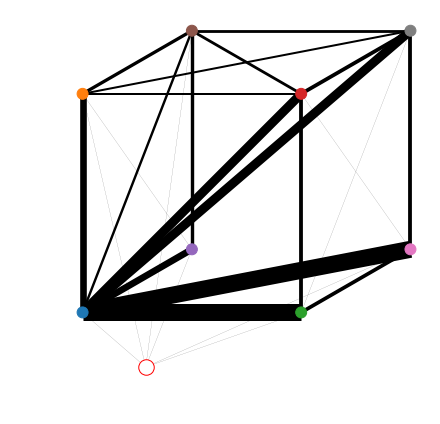

In [10]:
_, n1ref = with_references( [0])

When experimental data are available for some molecules, absolute binding free energy calculations are unnecessary. As shown in the figure above, all samplings are allocated to the relative binding free energy calculations, especially those to the reference molecule.

We use maximum likelihood estimator to compute the individual binding free energies using both the binding free energy calculations and the reference experimental values.

In [11]:
def estimate_dG_with_references( references, n, s=sCOX2):
    # We will mock up some results of binding free energy calculations
    dG0 = cox2['dG0']
    delta = cox2['delta']
    ddG, isigma2 = mockupBFEresults( n, s, dG0)
    dG0r, deltar = reference_values( references)
    dG = networkBFEdG( ddG, isigma2, dG0r, deltar)
    cov = covariance( s, n, deltar)
    
    fig, ax = plt.subplots( figsize=(5,5))
    ax.errorbar( dG0, dG, fmt='o', xerr=delta, yerr=np.sqrt(np.diag( cov)))
    ax.plot( dG0[references], dG[references], 'ro', zorder=10)
    gmin, gmax = np.min( dG0), np.max( dG0)
    ax.plot( [gmin, gmax], [gmin, gmax], '--')
    ax.set_xlim( ax.get_ylim())
    ax.set_aspect( 1.)
    ax.set_xlabel('Experiment')
    ax.set_ylabel('BFE')
    
    return fig, dG, cov

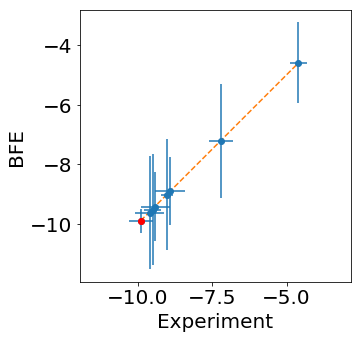

In [12]:
_, dG1ref, cov1ref = estimate_dG_with_references( [0], n1ref)

As we increase the total number of sampling points, some of them will be allocated to absolute binding free energy calculations.

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.0000e+01  1e+04  8e-01  2e+00  1e+00
 1:  3.8293e+00  3.0167e+00  2e+02  1e-02  4e-02  2e-02
 2:  3.7767e+00  3.7305e+00  2e+01  2e-03  5e-03  6e-02
 3:  3.1653e+00  3.1567e+00  6e+00  5e-04  1e-03  2e-02
 4:  3.2288e+00  3.2273e+00  5e+00  4e-04  1e-03  2e-02
 5:  2.9125e+00  2.9131e+00  1e+00  9e-05  3e-04  6e-03
 6:  2.6954e+00  2.6969e+00  6e-01  4e-05  1e-04  4e-03
 7:  2.6741e+00  2.6752e+00  3e-01  3e-05  8e-05  3e-03
 8:  2.6268e+00  2.6270e+00  6e-02  4e-06  1e-05  5e-04
 9:  2.6128e+00  2.6129e+00  9e-03  7e-07  2e-06  8e-05
10:  2.6108e+00  2.6108e+00  2e-03  1e-07  4e-07  1e-05
11:  2.6105e+00  2.6105e+00  5e-04  3e-08  1e-07  4e-06
12:  2.6104e+00  2.6104e+00  9e-05  6e-09  2e-08  8e-07
13:  2.6104e+00  2.6104e+00  5e-06  4e-10  1e-09  5e-08
14:  2.6104e+00  2.6104e+00  2e-07  1e-11  4e-11  2e-09
Optimal solution found.


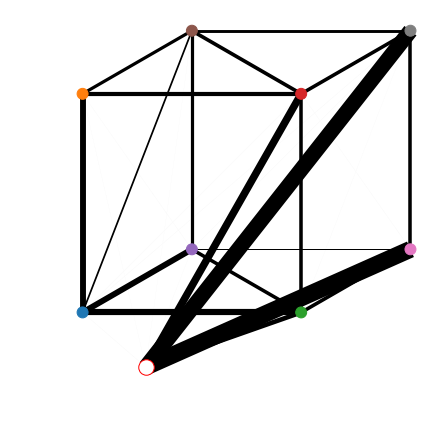

In [13]:
_, n1reflargeN = with_references( [0], N=10000.)

As this shows, absolute binding free energy calculations are preferentialy used on molecules that are most distant from the reference molecule.

### With multiple reference molecules

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -8.2000e+01  1e+03  8e-01  2e+00  1e+00
 1:  4.8886e+00 -1.1822e+01  3e+02  2e-01  5e-01  3e-01
 2:  7.1634e+00 -8.7964e+00  2e+02  2e-01  5e-01  5e-01
 3:  9.9353e+00  7.8549e+00  3e+01  2e-02  7e-02  1e-01
 4:  7.6820e+00  7.0000e+00  1e+01  7e-03  2e-02  5e-02
 5:  7.2287e+00  6.7618e+00  7e+00  5e-03  1e-02  4e-02
 6:  6.0491e+00  5.8558e+00  3e+00  2e-03  6e-03  2e-02
 7:  5.9447e+00  5.8060e+00  2e+00  2e-03  5e-03  2e-02
 8:  5.5627e+00  5.5255e+00  6e-01  4e-04  1e-03  5e-03
 9:  5.4896e+00  5.4662e+00  4e-01  3e-04  8e-04  3e-03
10:  5.3787e+00  5.3772e+00  3e-02  2e-05  5e-05  2e-04
11:  5.3719e+00  5.3717e+00  3e-03  2e-06  6e-06  3e-05
12:  5.3709e+00  5.3709e+00  9e-05  6e-08  2e-07  7e-07
13:  5.3709e+00  5.3709e+00  1e-05  7e-09  2e-08  9e-08
14:  5.3709e+00  5.3709e+00  1e-06  9e-10  3e-09  1e-08
Optimal solution found.


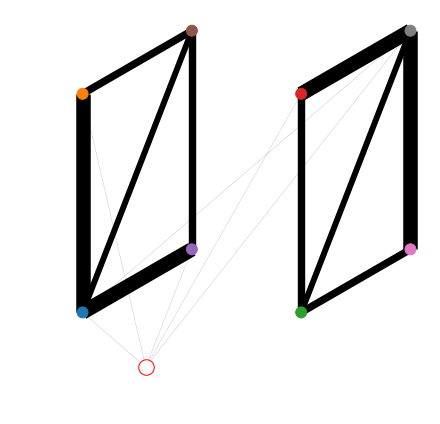

In [14]:
_, n2ref = with_references( [0, 7])

In this case, the network becomes two disconnected subnetworks, each connected to a different reference molecule.

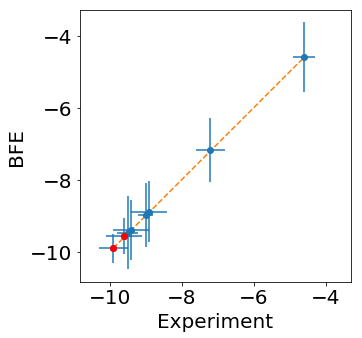

In [15]:
_, dG2ref, cov2ref = estimate_dG_with_references( [0, 7], n2ref)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -8.2000e+01  1e+04  6e-01  2e+00  1e+00
 1:  3.4920e+00  2.5266e+00  1e+02  7e-03  3e-02  1e-02
 2:  2.0005e+00  1.9743e+00  3e+00  2e-04  8e-04  3e-04
 3:  1.8535e+00  1.8451e+00  2e+00  9e-05  4e-04  4e-03
 4:  1.7783e+00  1.7751e+00  1e+00  7e-05  3e-04  6e-03
 5:  1.7672e+00  1.7659e+00  8e-01  4e-05  2e-04  4e-03
 6:  1.7162e+00  1.7161e+00  2e-01  9e-06  4e-05  1e-03
 7:  1.6923e+00  1.6923e+00  6e-02  3e-06  1e-05  4e-04
 8:  1.6896e+00  1.6896e+00  5e-02  3e-06  1e-05  4e-04
 9:  1.6798e+00  1.6798e+00  7e-03  4e-07  2e-06  6e-05
10:  1.6782e+00  1.6782e+00  1e-03  6e-08  2e-07  9e-06
11:  1.6780e+00  1.6780e+00  4e-04  2e-08  9e-08  3e-06
12:  1.6779e+00  1.6779e+00  4e-05  2e-09  9e-09  4e-07
13:  1.6779e+00  1.6779e+00  7e-06  4e-10  2e-09  6e-08
14:  1.6779e+00  1.6779e+00  1e-06  6e-11  3e-10  1e-08
Optimal solution found.


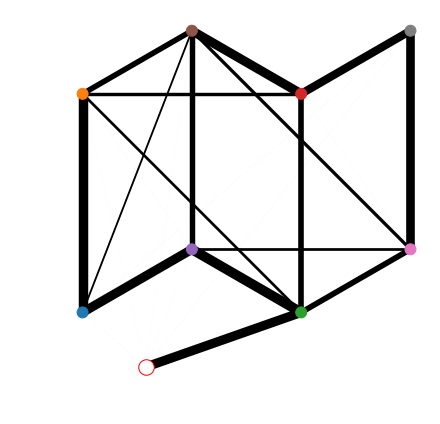

In [16]:
_, n2reflargeN = with_references( [0, 7], N=10000.)

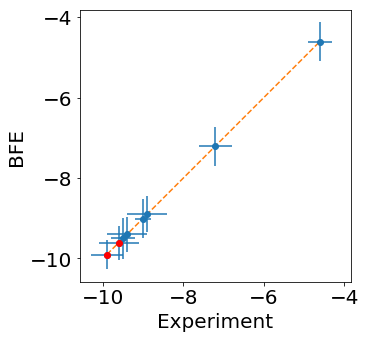

In [17]:
_, dG2ref, cov2ref = estimate_dG_with_references( [0, 7], n2reflargeN)